In [1]:
from numpy import genfromtxt
import tensorflow as tf
import tensorflow.keras as keras
'''#from keras.models import Sequential
from keras.layers import Dense, Input, Lambda, Dropout
from keras import regularizers
#from keras.layers import Dropout
from keras.constraints import maxnorm
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Model
from keras import regularizers
#from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras import objectives
from keras.models import model_from_json
from keras.layers import Input, Dense, Convolution1D, MaxPooling1D, UpSampling1D, AveragePooling1D, Flatten ,Reshape,ZeroPadding1D,Cropping1D
from keras.models import Model
#from keras.callbacks import TensorBoard
from keras.regularizers import l2, l1
from keras import optimizers
from keras.layers.noise import GaussianNoise
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.layers import Dense,concatenate, Input,TimeDistributed,LSTM, Lambda, Dropout, Reshape, Conv1D, Flatten, UpSampling1D, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras import backend as K'''
from PIL import Image

import os
import sys
import itertools
#import keras_internal_model
import pandas as pd
import numpy as np
#import train_tools as tt
from numpy import genfromtxt
from time import time

import csv

tf.compat.v1.enable_v2_behavior()


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])
  except RuntimeError as e:
    print(e)
    
    
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_logical_devices('GPU')

import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

GPUs:  1


In [2]:
def n2c(n,stride=180): #number to coordinate
    row = n//stride
    col = n%stride
    return (row,col)

def c2n(c,stride=180): #coordinate to number
    return c[0]*stride + c[1]

def get_deltas(c1,c2):
    n_positions=180
    dp = c2[0]-c1[0]
    
    dt = c2[1]-c1[1]
    if dt > (n_positions/2):
        dt -= n_positions
    elif dt <= -(n_positions/2):
        dt += n_positions
    
    return dp,dt

In [3]:
dataset_path = '/home/pico/uni/romi/rl_sony/arabidopsis_image_sets'
plants = ['000_2d', '001_2d','003_2d','006_2d','009_2d']

dest_path = '/home/pico/uni/romi/rl_sony/best_next_move_3d_reconstruction/data/'
#if not os.path.exists(dest_path):
#    os.makedirs(dest_path)

sample_files_path = os.path.join(dest_path,'raw_samples')

index_frame = {'img':[], 'dp0':[],'dt0':[], 'dp1':[],'dt1':[],'dp2':[],'dt2':[]}

In [4]:
for plant in plants:
    #ra samples file where sets of image numbers (input, outputs) are defined
    df = pd.read_csv(os.path.join(sample_files_path, plant+'_classifier_samples.csv'),
                    names=['i0','i1','i2','i3'],
                    usecols=(0,1,2,3))
    #grayscale image dataset
    plant_img_path = os.path.join(dataset_path,plant,'gray_imgs_82')

    #folder where new merged images will be stored
    merged_dest_path = os.path.join(dest_path,'imgs',plant)
    if not os.path.exists(merged_dest_path):
        os.makedirs(merged_dest_path)

    for index,contents in df.iterrows():
        #convert image index to coordinates
        c0 = n2c(contents['i0'])
        c1 = n2c(contents['i1'])
        c2 = n2c(contents['i2'])
        c3 = n2c(contents['i3'])

        #get position increments 
        d0 = get_deltas(c0,c1)
        d1 = get_deltas(c1,c2)
        d2 = get_deltas(c2,c3)

        #open and merge images
        im0 = cv2.imread(os.path.join(plant_img_path, str(c0[0]).zfill(3)+'_'+str(c0[1]).zfill(3)+'.png'),0)
        im1 = cv2.imread(os.path.join(plant_img_path, str(c1[0]).zfill(3)+'_'+str(c1[1]).zfill(3)+'.png'),0)
        im2 = cv2.imread(os.path.join(plant_img_path, str(c2[0]).zfill(3)+'_'+str(c2[1]).zfill(3)+'.png'),0)
        merged = np.stack((im0,im1,im2),axis=2)

        #save merged image in dest folder
        fname = str(contents['i0']).zfill(3)+'_'+str(contents['i1']).zfill(3)+'_'+str(contents['i2']).zfill(3)+'.png'
        #print(fname)
        dest= os.path.join(merged_dest_path,fname)
        cv2.imwrite(dest,merged)

        #add entry to index file
        im_path = os.path.join(plant,fname)
        #['img','dp0', 'dt0','dp1', 'dt1','dp2','dt2']
        index_frame['img'].append(im_path)  
        index_frame['dp0'].append(d0[0]) 
        index_frame['dt0'].append(d0[1]) 
        index_frame['dp1'].append(d1[0]) 
        index_frame['dt1'].append(d1[1]) 
        index_frame['dp2'].append(d2[0]) 
        index_frame['dt2'].append(d2[1])

index_frame = pd.DataFrame(index_frame, columns = ['img','dp0', 'dt0','dp1', 'dt1','dp2','dt2'])
index_frame = index_frame.sample(random_state=1,frac=1) #shuffle items
index_frame.to_csv(os.path.join(dest_path,'samples_idx.csv'),index=False)

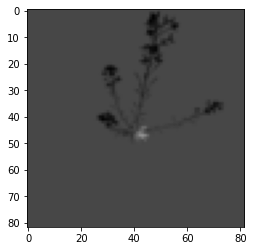

In [5]:
plt.imshow(im2, cmap='gray', vmin=0, vmax=255)